In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
g = torch.Generator().manual_seed(2147483647)

In [7]:
class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool = True):
        self.weight = torch.randn(
            (fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.bias is not None else [])

In [8]:
class BatchNorm1d:

    def __init__(self, dim, momentum=0.1, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon

        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [10]:
import unittest


class TestLinearLayer(unittest.TestCase):

    def test_forward_pass(self):
        layer = Linear(3, 2)
        x = torch.ones((1, 3))
        out = layer(x)
        self.assertEqual(out.shape, (1, 2))

    def test_no_bias(self):
        layer = Linear(3, 2, bias=False)
        x = torch.ones((1, 3))
        out = layer(x)
        self.assertIsNotNone(out)
        self.assertIsNone(layer.bias)


class TestBatchNorm1d(unittest.TestCase):

    def test_training_forward_pass(self):
        bn = BatchNorm1d(dim=4, momentum=0.1)
        x = torch.randn((10, 4))
        out = bn(x)
        self.assertEqual(out.shape, x.shape)
        self.assertFalse(torch.allclose(bn.running_mean, torch.zeros(4)))
        self.assertFalse(torch.allclose(bn.running_var, torch.ones(4)))

    def test_inference_forward_pass(self):
        bn = BatchNorm1d(dim=4, momentum=0.1)
        x = torch.randn((10, 4))
        out = bn(x)
        self.assertEqual(out.shape, x.shape)
        running_mean_before = bn.running_mean.clone()
        running_var_before = bn.running_var.clone()

        bn.training = False
        x = torch.randn((10, 4))
        out = bn(x)
        self.assertTrue(torch.allclose(bn.running_mean, running_mean_before))
        self.assertTrue(torch.allclose(bn.running_var, running_var_before))


unittest.main(argv=[''], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


In [11]:
n_embd = 10
n_hidden = 100

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3   # trial: [1, 5/3, 3]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [12]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 80000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if (i == 0) or (i == max_steps - 1) or ((i+1) % 10000 == 0):
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item()
                  for p in parameters])

    if i > 999:
        break

      0/ 200000: 3.3028


layer  1 (      Tanh): mean -0.01, std 0.78, saturated: 23.94%
layer  3 (      Tanh): mean -0.00, std 0.73, saturated: 12.59%
layer  5 (      Tanh): mean +0.03, std 0.72, saturated: 11.06%
layer  7 (      Tanh): mean -0.01, std 0.72, saturated: 10.69%
layer  9 (      Tanh): mean -0.02, std 0.71, saturated: 10.62%


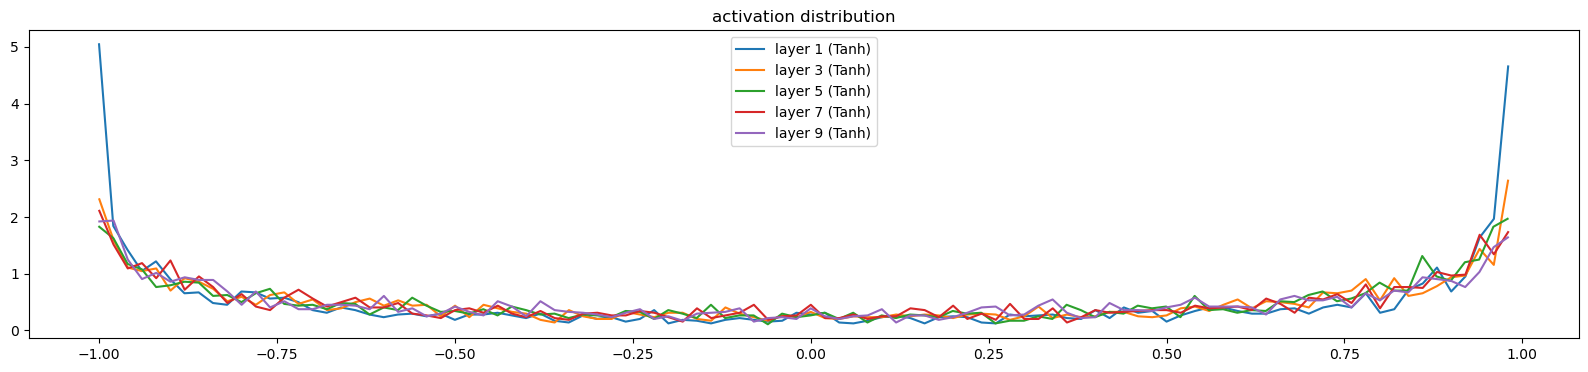

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %2d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %
              (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')
plt.show()

layer  1 (      Tanh): mean -0.000019, std 3.359432e-03
layer  3 (      Tanh): mean -0.000166, std 3.177373e-03
layer  5 (      Tanh): mean +0.000054, std 2.991393e-03
layer  7 (      Tanh): mean -0.000039, std 2.641990e-03
layer  9 (      Tanh): mean +0.000014, std 2.272967e-03


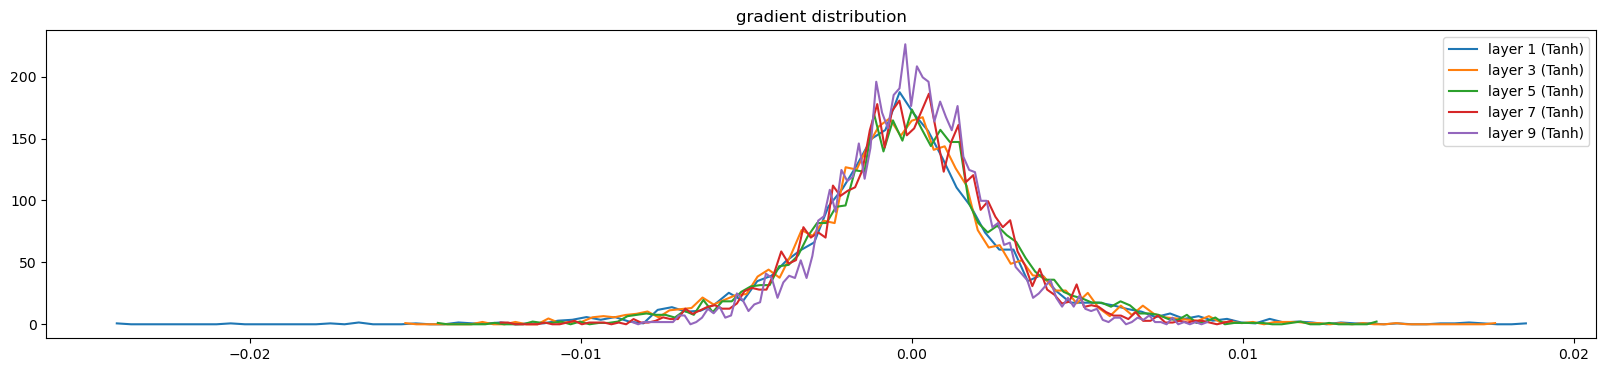

In [14]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %2d (%10s): mean %+f, std %e' %
              (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
plt.show()

weight   (27, 10) | mean +0.000213 | std 1.238248e-02 | grad:data ratio 1.296136e-02
weight  (30, 100) | mean +0.000281 | std 1.084512e-02 | grad:data ratio 3.559977e-02
weight (100, 100) | mean -0.000041 | std 7.971025e-03 | grad:data ratio 4.699399e-02
weight (100, 100) | mean +0.000065 | std 7.264585e-03 | grad:data ratio 4.347505e-02
weight (100, 100) | mean -0.000036 | std 6.379739e-03 | grad:data ratio 3.800537e-02
weight (100, 100) | mean -0.000000 | std 4.978621e-03 | grad:data ratio 2.961998e-02
weight  (100, 27) | mean -0.000000 | std 2.007691e-02 | grad:data ratio 2.942998e-01


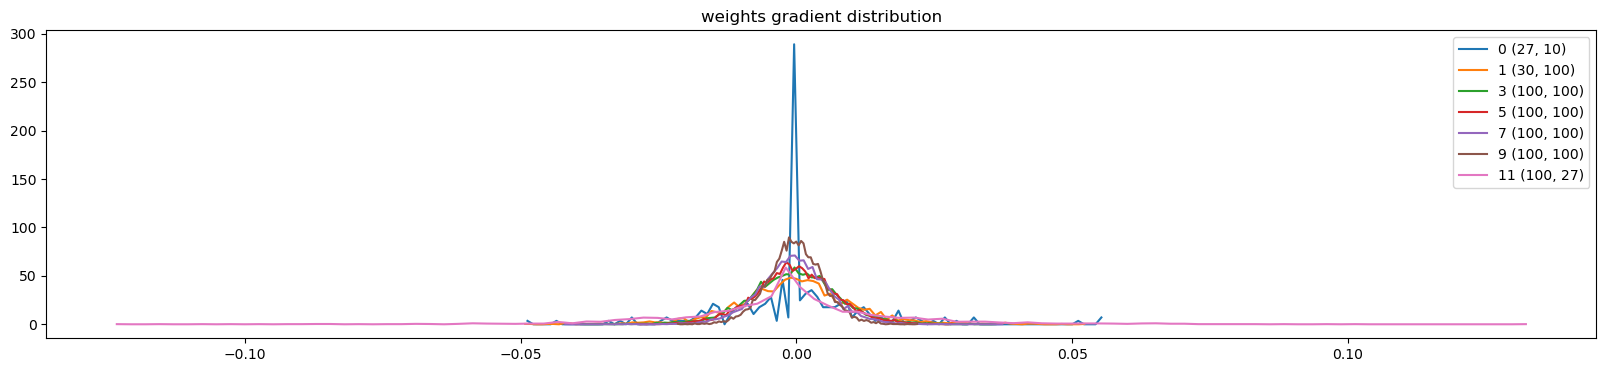

In [15]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' %
              (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')
plt.show()

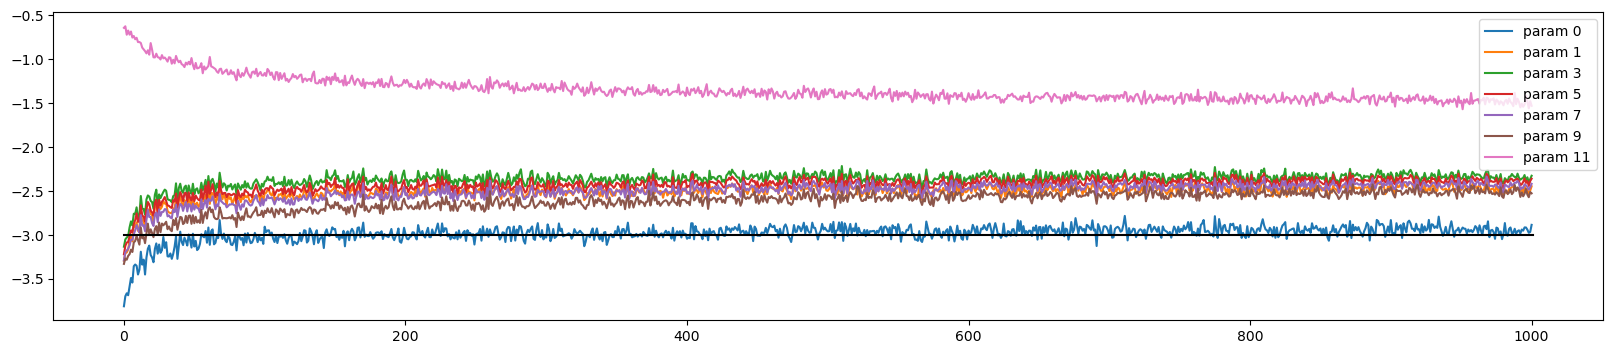

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.show()